In [1]:
from obspy import read
from obspy import UTCDateTime
import numpy as np

# Assuming the waveform data file is named 'waveform_data.mseed'
# Replace with the actual path to your waveform data file
try:
    st = read('../Data/0121Dapu.mseed')
except Exception as e:
    print(f"Error loading waveform data: {e}")
    st = None

if st:
    # Define time windows for slicing
    t1 = UTCDateTime(2025, 1, 20, 16, 17, 16)
    t2 = UTCDateTime(2025, 1, 20, 16, 17, 34)

    # Slice the stream
    st_sliced_1 = st.slice(t1, t1 + 5)
    st_sliced_2 = st.slice(t2, t2 + 5) # Use t2 to t2+5 as per your example

    # Combine sliced streams if needed, or process separately
    # For this example, let's assume we are processing st_sliced_2 as in your example
    st2 = st_sliced_2.copy() # Work on a copy to avoid modifying the original stream

    # Perform normalization and detrending
    st2.normalize()
    st2.detrend()

    processed_data = []
    labels = []

    # Process traces and assign labels based on your logic
    # Assuming the traces in st2 correspond to the data points you want to label
    # and that the labeling logic you provided applies to these traces.

    # Ensure the number of traces in st2 matches the number of labels you intend to create
    # based on your original code's slicing ([:129] and [129:])

    # Let's recreate the processed_data and labels based on your provided code structure
    all_processed_traces = [i.data for i in st2] # Get data from all traces in st2

    # Based on your original slicing and labeling logic:
    # First 129 traces in st2 are for training
    X_train_data = all_processed_traces[:129]
    Y_train_labels = [1 if st2[i].stats.station in ["ALS", "CHN8", "CHY", "SCL", "ELD"] else 0 for i in range(129)]

    # Remaining traces in st2 are for testing
    X_test_data = all_processed_traces[129:]
    Y_test_labels = [1 if st2[i+129].stats.station in ["SSD", "TAI", "TAI1", "WDL", "WGK", "WSF", "YUS"] else 0 for i in range(len(st2) - 129)]

    print("Waveform data loaded and processed with labels.")
    print(f"Number of training data points: {len(X_train_data)}")
    print(f"Number of testing data points: {len(X_test_data)}")

else:
    print("Failed to load waveform data.")

Waveform data loaded and processed with labels.
Number of training data points: 129
Number of testing data points: 72


In [3]:
processed_data

[]

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np

# Convert processed_data and labels to PyTorch tensors
processed_data_tensor = torch.tensor(np.array(processed_data), dtype=torch.float32)
labels_tensor = torch.tensor(np.array(labels), dtype=torch.long)

# Create a TensorDataset
dataset = TensorDataset(processed_data_tensor, labels_tensor)

# Split the dataset into training and testing sets (80/20 split)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print("Data successfully converted to tensors, dataset created, split, and DataLoaders created.")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

ValueError: num_samples should be a positive integer value, but got num_samples=0

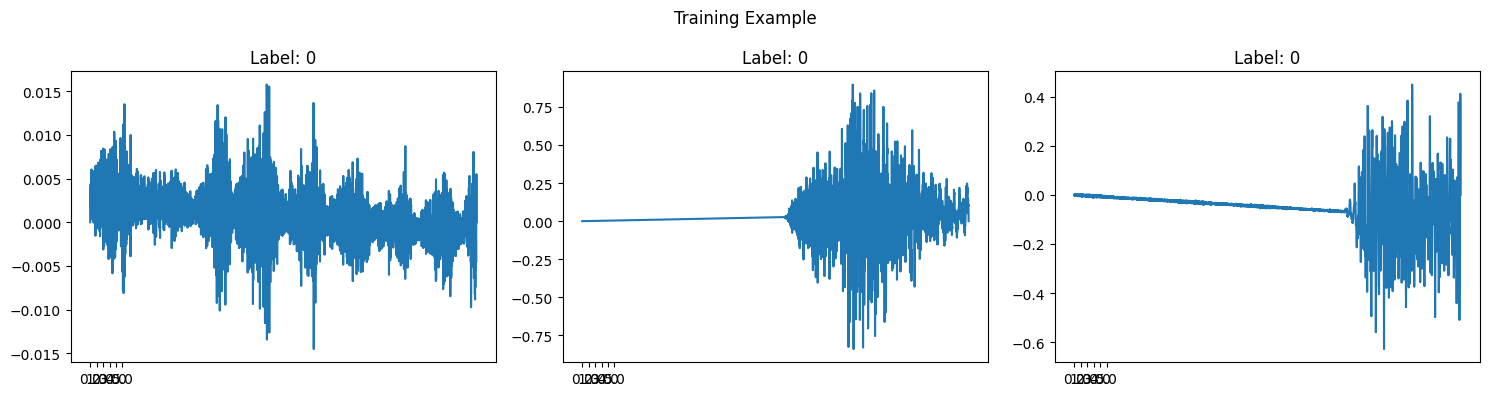

In [17]:
import matplotlib.pyplot as plt
train_features, train_labels = next(iter(train_loader))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):   
    data = train_features[i]
    label = train_labels[i]
    axes[i].plot(data.numpy())
    axes[i].set_title(f"Label: {label}")
    axes[i].set_xticks(np.linspace(0, 501, 6), np.linspace(0, 5, 6))

fig.suptitle("Training Example")
plt.tight_layout()
plt.savefig("train_result.png", dpi = 300)
plt.show()

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Assuming the input is a 1D tensor of size 6000
        # We'll use Conv1d for 1D data
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)

        # Calculate the output size after convolutional and pooling layers
        # Input size: (batch_size, 1, 6000)
        # After conv1 (kernel_size=3, stride=1, padding=0): (batch_size, 32, 6000 - 3 + 1) = (batch_size, 32, 5998)
        # After pool (kernel_size=2, stride=2): (batch_size, 32, 5998 // 2) = (batch_size, 32, 2999)
        # After conv2 (kernel_size=3, stride=1, padding=0): (batch_size, 64, 2999 - 3 + 1) = (batch_size, 64, 2997)
        # After pool (kernel_size=2, stride=2): (batch_size, 64, 2997 // 2) = (batch_size, 64, 1498) # Integer division

        self.fc1 = nn.Linear(64 * 1498, 64) # Adjusted input size for the first fully connected layer
        self.fc2 = nn.Linear(64, 2) # Assuming 2 output classes (earthquake/no earthquake)

    def forward(self, x):
        # Input x shape: (batch_size, 6000)
        # Conv1d expects input shape (batch_size, channels, length)
        x = x.unsqueeze(1) # Add a channel dimension: (batch_size, 1, 6000)

        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))

        # Flatten the output for the fully connected layer
        x = x.view(-1, 64 * 1498) # Adjusted flattening

        x = torch.relu(self.fc1(x))
        x = self.fc2(x) # Output layer (no activation for CrossEntropyLoss)
        return x

model = Net()
print(model)

Net(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=95872, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} Loss: {loss.item()}")

Epoch 1/5
Epoch 1 Loss: 0.06904077529907227
Epoch 2/5
Epoch 2 Loss: 0.02789786271750927
Epoch 3/5
Epoch 3 Loss: 0.016807449981570244
Epoch 4/5
Epoch 4 Loss: 0.011669774539768696
Epoch 5/5
Epoch 5 Loss: 0.008783685974776745


In [10]:
# 1. Set the model to evaluation mode
model.eval()

# 2. Initialize variables to track correct and total predictions
correct = 0
total = 0

# 3. Iterate through the test_loader
with torch.no_grad(): # Disable gradient calculation for inference
    for inputs, labels in test_loader:
        # 5. Pass the inputs through the model
        outputs = model(inputs)

        # 6. Get the predicted labels
        _, predicted = torch.max(outputs.data, 1)

        # 7. Update correct and total counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 8. Calculate and print the accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test data: {accuracy:.2f}%')

Accuracy of the model on the test data: 100.00%
